# Predicting Employee Churn


## Description

There are many problems in HR that can be addressed using data-driven approach. Among those are decisions related to employee hiring and retention, performance evaluation, collaboration and else. Here we will concentrate on Predicting employee turnover.

Employee turnover is the process of employees leaving the company also known as employee attrition or employee churn. When skilled employees leave, this can be very costly for the company, thus firms are interested in predicting turnover beforehand. Having that information in hand, companies can change their strategy to retain good workers or start the hiring process of new employees on time.

## Importing libraries

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import precision_score,recall_score,roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

## Data Acquisition & Overview

In [28]:
# Import pandas (as pd) to read the data
import pandas as pd

# Read "turnover.csv" and save it in a DataFrame called data
data = pd.read_csv("datasets/turnover.csv")

# Take a quick look to the first 5 rows of data
print(data.head())

# Get some information on the types of variables in data
data.info()

   satisfaction  evaluation  number_of_projects  ...  promotion  department  salary
0          0.38        0.53                   2  ...          0       sales     low
1          0.80        0.86                   5  ...          0       sales  medium
2          0.11        0.88                   7  ...          0       sales  medium
3          0.72        0.87                   5  ...          0       sales     low
4          0.37        0.52                   2  ...          0       sales     low

[5 rows x 10 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   satisfaction          14999 non-null  float64
 1   evaluation            14999 non-null  float64
 2   number_of_projects    14999 non-null  int64  
 3   average_montly_hours  14999 non-null  int64  
 4   time_spend_company    14999 non-null  int64  
 5   wo

The dataset has a total of 14999 samples and 10 columns in which 8 are numerical and 2 are object type. Those are department and salary which are actually categorical in which salary is a ordinal variable and department is a nominal variable.

In [29]:
# Print the unique values of the "department" column
print(data.department.unique())

# Print the unique values of the "salary" column
print(data.salary.unique())

['sales' 'accounting' 'hr' 'technical' 'support' 'management' 'IT'
 'product_mng' 'marketing' 'RandD']
['low' 'medium' 'high']


## Transforming categoricals

In [30]:
# Change the type of the "salary" column to categorical
data.salary = data.salary.astype('category')

# Provide the correct order of categories
data.salary = data.salary.cat.reorder_categories(['low', 'medium', 'high'])

# Encode categories
data.salary = data.salary.cat.codes

In [31]:
# Get dummies and save them inside a new DataFrame
departments = pd.get_dummies(data.department)

# Take a quick look to the first 5 rows of the new DataFrame called departments
print(departments.head())

   IT  RandD  accounting  hr  ...  product_mng  sales  support  technical
0   0      0           0   0  ...            0      1        0          0
1   0      0           0   0  ...            0      1        0          0
2   0      0           0   0  ...            0      1        0          0
3   0      0           0   0  ...            0      1        0          0
4   0      0           0   0  ...            0      1        0          0

[5 rows x 10 columns]


There are 10 departments in the dataset, so we get 10 columns. 

In [32]:
# Drop the "accounting" column to avoid "dummy trap"
departments = departments.drop("accounting", axis=1)

# Drop the old column "department" as you don't need it anymore
data = data.drop("department", axis=1)

# Join the new DataFrame "departments" to your employee dataset: done
data = data.join(departments)

## Descriptive Statistics

In [33]:
# Use len() function to get the total number of observations and save it as the number of employees
n_employees = len(data)

# Print the number of employees who left/stayed
print(data.churn.value_counts())

# Print the percentage of employees who left/stayed
print(data.churn.value_counts()/n_employees*100)

0    11428
1     3571
Name: churn, dtype: int64
0    76.191746
1    23.808254
Name: churn, dtype: float64


We can see, 11,428 employees stayed, which accounts for about 76% of the total employee count. Similarly, 3,571 employees left, which accounts for about 24% of them.

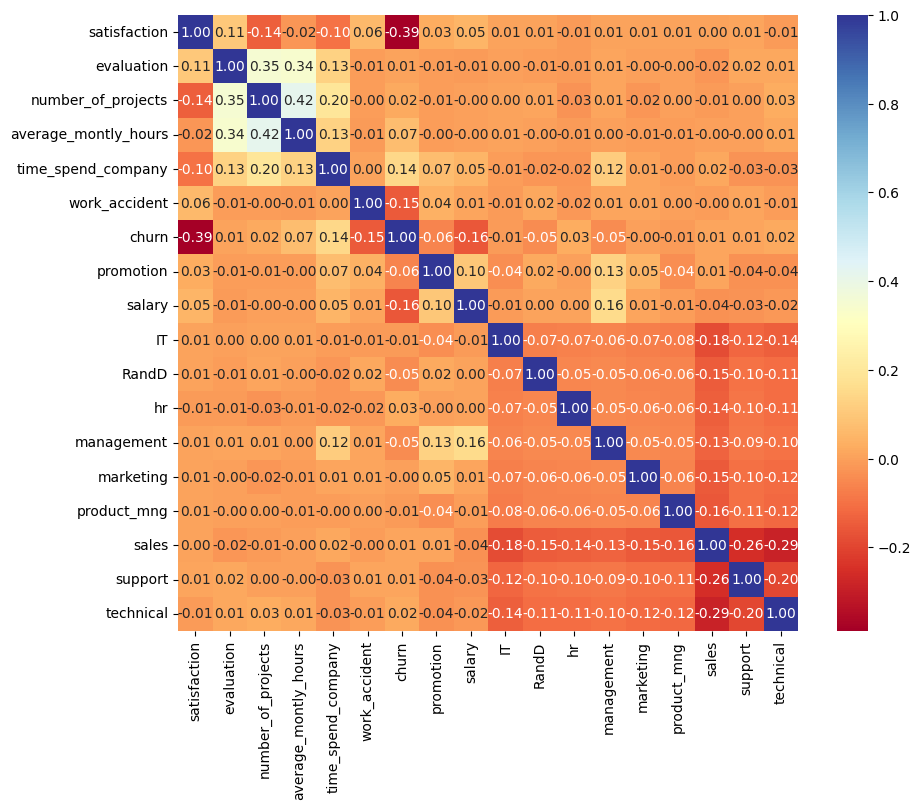

In [34]:
plt.figure(figsize=(10, 8)) 
corr_matrix = data.corr()
sns.heatmap(corr_matrix,annot=True, cmap="RdYlBu", fmt=".2f")
plt.show()


- The relationship between evaluation and work_accident is negative.

- There is a negative correlation between employee satisfaction and churn.

- Increase in the number_of_projects is associated with an increase in average_monthly_hours.

## Predicting Employee Turnover

### Splitting the data

In [35]:
# Set the target and features

# Choose the dependent variable column (churn) and set it as target
target = data.churn

# Drop column churn and set everything else as features
features = data.drop("churn",axis=1)

In [36]:
# Use that function to create the splits both for target and for features and Set the test sample to be 25% of your observations
target_train, target_test, features_train, features_test = train_test_split(target,features,test_size=0.25,random_state=42)

We have set aside 25% of our data to evaluate our model performance after training.

### Using Decision trees

Decision trees are quite popular in HR analytics and it has 2 reasons for being popular:
- It is able to provide accurate predictions .
- It can be used to understand factors that are driving the decision to leave the company.

In [37]:
# Initialize it and call model by specifying the random_state parameter
model = DecisionTreeClassifier(random_state=42)

# Apply a decision tree model to fit features to the target
model.fit(features_train, target_train)

DecisionTreeClassifier(random_state=42)

In [38]:
# Check the accuracy score of the prediction for the training set
print("Training Accuracy",model.score(features_train,target_train)*100)

# Check the accuracy score of the prediction for the test set
print("Testing Accuracy",model.score(features_test,target_test)*100)

Training Accuracy 100.0
Testing Accuracy 97.22666666666666


The algorithm did perfectly on the training set. On the testing set, it was able to correctly predict if an employee would leave or not in almost 98% of the cases!But this could also be the case of overfitting.

In [39]:
# Export the tree to a dot file
export_graphviz(model,"tree.dot")

After visualizing the graph in webgraphviz.com, we can see that the tree has grown so large. This means it became so specific to training data only.

## Tuning Classifier

### Pruning the tree

In [40]:
# Initialize the DecisionTreeClassifier while limiting the depth of the tree to 5
model_depth_5 = DecisionTreeClassifier(max_depth=5, random_state=42)

# Fit the model
model_depth_5.fit(features_train,target_train)

# Print the accuracy of the prediction for the training set
print(model_depth_5.score(features_train,target_train)*100)

# Print the accuracy of the prediction for the test set
print(model_depth_5.score(features_test,target_test)*100)

97.71535247577563
97.06666666666666


### Limiting the sample size

In [41]:
# Initialize the DecisionTreeClassifier while limiting the sample size in leaves to 100
model_sample_100 = DecisionTreeClassifier(min_samples_leaf=100, random_state=42)

# Fit the model
model_sample_100.fit(features_train,target_train)

# Print the accuracy of the prediction (in percentage points) for the training set
print(model_sample_100.score(features_train,target_train)*100)

# Print the accuracy of the prediction (in percentage points) for the test set
print(model_sample_100.score(features_test,target_test)*100)

96.57747355320473
96.13333333333334


## Evaluating the model

If the target of our prediction is mostly to focus on those who are churning,then we focus on False Negatives.
Recall can be useful. Higher values of Recall correspond to lower values of False Negatives.


If we want to keep our attention on those who stay,then we focus on False Positive.
Specificity can be useful.Higher values of Specificity correspond to lower values of False Positive.


Precision score - % of leavers in reality

In [42]:
# Predict whether employees will churn using the test set
prediction = model.predict(features_test)

# Calculate precision score by comparing target_test with the prediction
precision_score(target_test, prediction)

0.9240641711229947

In [43]:
# Use the initial model to predict churn
prediction = model.predict(features_test)

# Calculate recall score by comparing target_test with the prediction
recall_score(target_test, prediction)

0.9632107023411371

But if our target is to have good predictions on both leavers & stayers then we focus on AUC score

In [44]:
# Use initial model to predict churn (based on features_test)
prediction = model.predict(features_test)

# Calculate ROC/AUC score by comparing target_test with the prediction
roc_auc_score(target_test, prediction)

0.9691623087590718

### Handling class imbalances

In [45]:
# Initialize the DecisionTreeClassifier 
model_depth_5_b = DecisionTreeClassifier(max_depth=5,class_weight="balanced",random_state=42)

# Fit the model
model_depth_5_b.fit(features_train,target_train)

# Print the accuracy of the prediction (in percentage points) for the test set
print(model_depth_5_b.score(features_test,target_test)*100)

93.70666666666668


### Comparing models

In [46]:
# Imbalanced model
# Print the recall score
print(recall_score(target_test,prediction))
# Print the ROC/AUC score
print(roc_auc_score(target_test,prediction))

# Balanced Model
# Initialize the model
model_depth_7_b = DecisionTreeClassifier(max_depth=7,class_weight="balanced",random_state=42)

# Fit it to the training component
model_depth_7_b.fit(features_train,target_train)
# Make prediction using test component
prediction_b = model_depth_7_b.predict(features_test)
# Print the recall score for the balanced model
print(recall_score(target_test,prediction_b))
# Print the ROC/AUC score for the balanced model
print(roc_auc_score(target_test,prediction_b))

0.9632107023411371
0.9691623087590718
0.9319955406911928
0.959863876199084


## Hyperparameter tuning

While the train/test split technique ensures that the model does not overfit the training set, hyperparameter tuning may result in overfitting the test component, since it consists in tuning the model to get the best prediction results on the test set. Therefore, it is recommended to validate the model on different testing sets. K-fold cross-validation allows us to achieve this.

In [47]:
# Generate values for maximum depth
depth = [i for i in range(5,21,1)]

# Generate values for minimum sample size
samples = [i for i in range(50,500,50)]

# Create the dictionary with parameters to be checked
parameters = dict(max_depth=depth, min_samples_leaf=samples)

In [48]:
# set up parameters: done
parameters = dict(max_depth=depth, min_samples_leaf=samples)

# initialize the param_search function using the GridSearchCV function, initial model and parameters above
param_search = GridSearchCV(model, parameters, cv=3)

# fit the param_search to the training dataset
param_search.fit(features_train, target_train)

# print the best parameters found
print(param_search.best_params_)

{'max_depth': 5, 'min_samples_leaf': 50}


It looks like the values that give us the best score are a minimum of samples per leaf of 50 and a maximum depth of 5.

## Features impacting Target

In [53]:
model_best=DecisionTreeClassifier(class_weight='balanced', max_depth=5,
                       min_samples_leaf=50, random_state=42)
model_best.fit(features_train,target_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=5,
                       min_samples_leaf=50, random_state=42)

In [54]:
# Calculate feature importances
feature_importances = model_best.feature_importances_

# Create a list of features: done
feature_list = list(features)

# Save the results inside a DataFrame using feature_list as an index
relative_importances = pd.DataFrame(index=feature_list, data=feature_importances, columns=["importance"])

# Sort the DataFrame to learn most important features
relative_importances.sort_values(by="importance", ascending=False)

,importance
satisfaction,0.453971
time_spend_company,0.397473
evaluation,0.104644
average_montly_hours,0.033545
number_of_projects,0.007103
technical,0.002226
hr,0.001038
promotion,0.000000
salary,0.000000
work_accident,0.000000


 It seems that satisfaction is by far the most impactful feature on the decision to leave the company or not.

In [55]:
# select only features with relative importance higher than 1%
selected_features = relative_importances[relative_importances.importance>0.01]

# create a list from those features: done
selected_list = selected_features.index

# transform both features_train and features_test components to include only selected features
features_train_selected = features_train[selected_list]
features_test_selected = features_test[selected_list]

As you can see, only 4 features have been retained out of the 17 original ones: 'satisfaction', 'evaluation', 'average_montly_hours', 'time_spend_company'. 

## Testing the best model

In [57]:
# Initialize the best model using parameters 
model_best = DecisionTreeClassifier(max_depth=5, min_samples_leaf=50, class_weight="balanced", random_state=42)

# Fit the model using only selected features from training set: done
model_best.fit(features_train_selected, target_train)

# Make prediction based on selected list of features from test set
prediction_best = model_best.predict(features_test_selected)

# Print the general accuracy of the model_best
print(model_best.score(features_test_selected, target_test) * 100)

# Print the recall score of the model predictions
print(recall_score(target_test, prediction_best) * 100)

# Print the ROC/AUC score of the model predictions
print(roc_auc_score(target_test, prediction_best) * 100)

93.46666666666667
91.9732441471572
92.95472582401672
